In [1]:
import pandas as pd

In [2]:
train = pd.read_csv('train_V2.csv')

In [3]:
test = pd.read_csv('test_V2.csv')

In [4]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [5]:
test.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
0,9329eb41e215eb,676b23c24e70d6,45b576ab7daa7f,0,0,51.46,0,0,0,73,...,1500,0,0.0,0,0.0,0,0,588.0,1,0
1,639bd0dcd7bda8,430933124148dd,42a9a0b906c928,0,4,179.10,0,0,2,11,...,1503,2,4669.0,0,0.0,0,0,2017.0,6,0
2,63d5c8ef8dfe91,0b45f5db20ba99,87e7e4477a048e,1,0,23.40,0,0,4,49,...,1565,0,0.0,0,0.0,0,0,787.8,4,0
3,cf5b81422591d1,b7497dbdc77f4a,1b9a94f1af67f1,0,0,65.52,0,0,0,54,...,1465,0,0.0,0,0.0,0,0,1812.0,3,0
4,ee6a295187ba21,6604ce20a1d230,40754a93016066,0,4,330.20,1,2,1,7,...,1480,1,0.0,0,0.0,0,0,2963.0,4,0


In [6]:
def rstr(df, pred=None):
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: [x.unique()])
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/obs) *100
    skewness = df.skew()
    kurtosis = df.kurt()
    print('Data shape: ', df.shape)
    
    if pred is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis', 'corr']
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis], axis=1)
    else:
        corr = df.corr()[pred]
        str =pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis, corr], axis=1, sort=False)
        corr_col = 'corr ' + pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis',  corr_col]
    str.columns = cols
    dtypes = str.types.value_counts()
    print('___________________________\nData types:\n',str.types.value_counts())
    print('___________________________')
    return str

# walkDistance, killplace, boosts, weaponsAcquired -> 매우 중요
## damageDealt, heals, kills, longest kills -> 중요

In [7]:
pd.set_option('display.max_rows', None)
details = rstr(train, 'winPlacePerc')
display(details.sort_values(by='corr winPlacePerc', ascending=False))

Data shape:  (4446966, 29)
___________________________
Data types:
 int64      19
float64     6
object      4
Name: types, dtype: int64
___________________________


,types,counts,distincts,nulls,missing ration,uniques,skewness,kurtosis,corr winPlacePerc
winPlacePerc,float64,4446965,3001,1,0.000022,"[[0.4444, 0.64, 0.7755, 0.1667, 0.1875, 0.037,...",0.098830,-1.245390,1.000000
walkDistance,float64,4446966,38599,0,0.000000,"[[244.8, 1434.0, 161.8, 202.7, 49.75, 34.7, 13...",1.092797,0.990674,0.810888
boosts,int64,4446966,27,0,0.000000,"[[0, 1, 2, 3, 4, 6, 5, 9, 7, 8, 11, 10, 13, 14...",1.949959,4.299439,0.634234
weaponsAcquired,int64,4446966,97,0,0.000000,"[[1, 5, 2, 3, 6, 4, 9, 7, 0, 8, 11, 10, 13, 14...",2.572307,59.355482,0.583806
damageDealt,float64,4446966,29916,0,0.000000,"[[0.0, 91.47, 68.0, 32.9, 100.0, 8.538, 51.6, ...",2.958920,20.112894,0.440507
heals,int64,4446966,63,0,0.000000,"[[0, 5, 2, 14, 12, 1, 8, 3, 4, 6, 9, 13, 7, 24...",3.444345,18.699277,0.427857
kills,int64,4446966,58,0,0.000000,"[[0, 1, 4, 2, 9, 3, 5, 6, 8, 7, 14, 13, 15, 12...",3.362907,27.438769,0.419916
longestKill,float64,4446966,28284,0,0.000000,"[[0.0, 58.53, 18.44, 49.83, 37.91, 9.158, 36.0...",3.944918,24.295268,0.410154
killStreaks,int64,4446966,18,0,0.000000,"[[0, 1, 2, 4, 3, 5, 6, 7, 10, 14, 8, 9, 11, 12...",1.252573,2.115793,0.377566
rideDistance,float64,4446966,33562,0,0.000000,"[[0.0, 0.0045, 2004.0, 6639.0, 1228.0, 1237.0,...",3.346419,14.812228,0.342915


## 선정한 중요 변수들 사이의 상관관계 분석

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

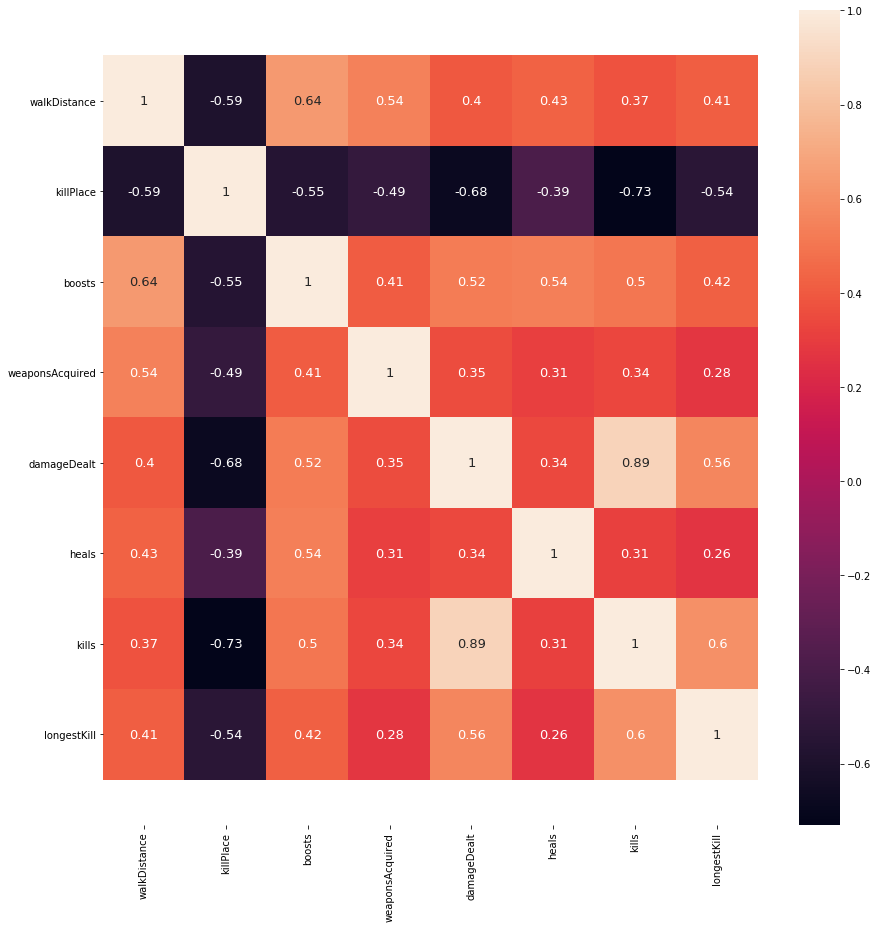

In [9]:
plt.figure(figsize=(13,13))
hm = sns.heatmap(train[['walkDistance', 'killPlace','boosts','weaponsAcquired','damageDealt','heals','kills','longestKill']].corr(), 
                 annot=True, annot_kws={'size':13})
bottom, top = hm.get_ylim()
hm.set_ylim(bottom+0.5, top-0.5)
plt.tight_layout()
plt.show()

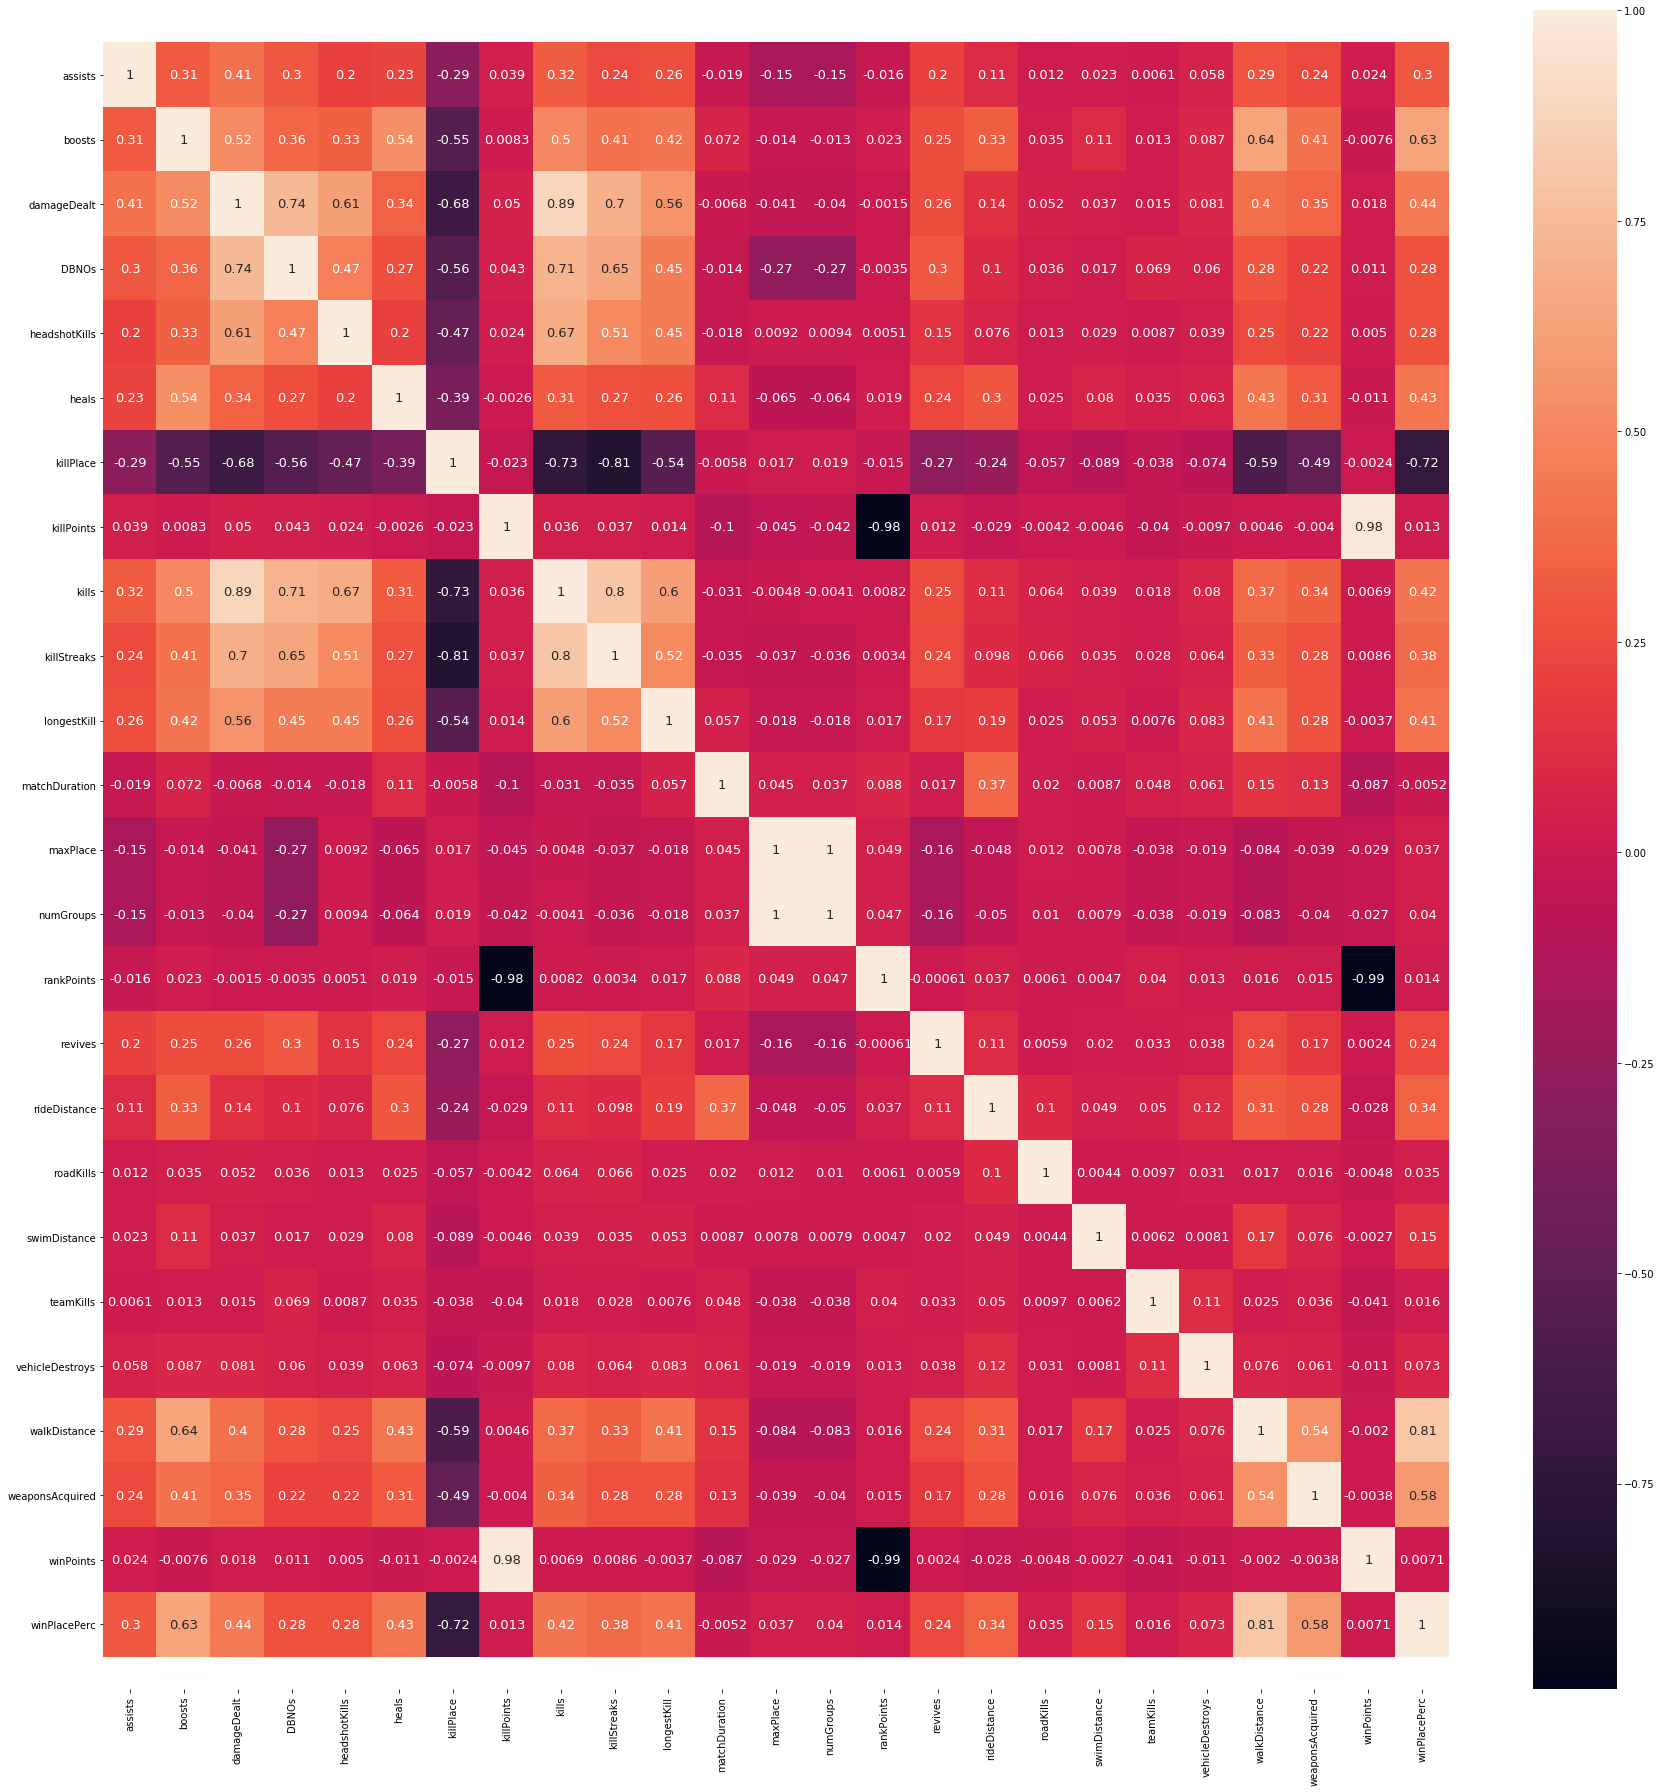

In [10]:
plt.figure(figsize=(25,25))
hm = sns.heatmap(train.corr(), 
                 annot=True, annot_kws={'size':13})
bottom, top = hm.get_ylim()
hm.set_ylim(bottom+0.5, top-0.5)
plt.tight_layout()
plt.show()

## walkDistance == 0이면서 kills > 0인 애들 -> 핵 의심

In [48]:
train = train.drop(train[train['walkDistance']==0][train['kills']>0].index, axis = 0)
test = test.drop(test[test['walkDistance']==0][test['kills']>0].index, axis = 0)

C:\Users\shjas\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
C:\Users\shjas\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


## 중요변수만으로 선형회귀 돌려보기

In [49]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [50]:
new_train = train[['walkDistance', 'killPlace','boosts','weaponsAcquired',
                   'damageDealt','heals','kills','longestKill','killStreaks','rideDistance','assists','DBNOs','headshotKills']]
target = train['winPlacePerc']
target = target.fillna(target.mean())

In [51]:
x_train, x_test, y_train, y_test = train_test_split(new_train, target, train_size = 0.7, test_size = 0.3, random_state = 25)

In [52]:
lr = LinearRegression()
ridge = Ridge(alpha = 0.5)
lasso = Lasso(alpha = 0.5)
elanet = ElasticNet(alpha = 0.5, l1_ratio = 0.5)
Xgb = XGBRegressor(max_depth=10, n_jobs=-1, n_estimators=500, tree_method='gpu_hist', gpu_id=0)
# cat = CatBoostRegressor(max_depth=10, n_estimators=500, task_type="GPU")

In [53]:
lr_model = lr.fit(x_train, y_train)
ridge_model = ridge.fit(x_train, y_train)
lasso_model = lasso.fit(x_train, y_train)
elanet_model = elanet.fit(x_train, y_train)
xgb_model = Xgb.fit(x_train, y_train)
# cat_model = cat.fit(x_train, y_train)

[16:59:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [54]:
print("훈련 스코어(lr)     : %.4f" % lr_model.score(x_train, y_train))
print("훈련 스코어(ridge)  : %.4f" % ridge_model.score(x_train, y_train))
print("훈련 스코어(lasso)  : %.4f" % lasso_model.score(x_train, y_train))
print("훈련 스코어(elanet) : %.4f" % elanet_model.score(x_train, y_train))
print("훈련 스코어(xgb)    : %.4f" % xgb_model.score(x_train, y_train))
# print("훈련 스코어(cat)    : %.4f" % cat_model.score(x_train, y_train))

훈련 스코어(lr)     : 0.8054
훈련 스코어(ridge)  : 0.8054
훈련 스코어(lasso)  : 0.7468
훈련 스코어(elanet) : 0.7534
훈련 스코어(xgb)    : 0.9094


In [55]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [56]:
print("예측 스코어(lr)     : %.4f" % r2_score(y_test, lr_model.predict(x_test))) 
print("예측 스코어(ridge)  : %.4f" % r2_score(y_test, ridge_model.predict(x_test)))
print("예측 스코어(lasso)  : %.4f" % r2_score(y_test, lasso_model.predict(x_test))) 
print("예측 스코어(elanet) : %.4f" % r2_score(y_test, elanet_model.predict(x_test))) 
print("예측 스코어(xgb)    : %.4f" % r2_score(y_test, xgb_model.predict(x_test)))
# print("예측 스코어(cat)    : %.4f" % r2_score(y_test, cat_model.predict(x_test)))

예측 스코어(lr)     : 0.8058
예측 스코어(ridge)  : 0.8058
예측 스코어(lasso)  : 0.7476
예측 스코어(elanet) : 0.7542
예측 스코어(xgb)    : 0.8985


In [57]:
print("예측 mae(lr)     : %.4f" % mean_absolute_error(y_test, lr_model.predict(x_test))) 
print("예측 mae(ridge)  : %.4f" % mean_absolute_error(y_test, ridge_model.predict(x_test))) 
print("예측 mae(lasso)  : %.4f" % mean_absolute_error(y_test, lasso_model.predict(x_test))) 
print("예측 mae(elanet) : %.4f" % mean_absolute_error(y_test, elanet_model.predict(x_test)))
print("예측 mae(xgb)    : %.4f" % mean_absolute_error(y_test, xgb_model.predict(x_test)))
# print("예측 mae(cat)    : %.4f" % mean_absolute_error(y_test, cat_model.predict(x_test)))

예측 mae(lr)     : 0.0994
예측 mae(ridge)  : 0.0994
예측 mae(lasso)  : 0.1205
예측 mae(elanet) : 0.1180
예측 mae(xgb)    : 0.0703


## matchType별 그룹화, 듀오 이상인 경우는 게임 플레이 관련 데이터 전부 팀별 평균으로 대체

In [20]:
matchtype = train.matchType.unique()

In [21]:
matchtype

array(['squad-fpp', 'duo', 'solo-fpp', 'squad', 'duo-fpp', 'solo',
       'normal-squad-fpp', 'crashfpp', 'flaretpp', 'normal-solo-fpp',
       'flarefpp', 'normal-duo-fpp', 'normal-duo', 'normal-squad',
       'crashtpp', 'normal-solo'], dtype=object)

## squad-### : 4
## duo-### : 2
## solo-### : 1
## crash###, flare### : 0

In [22]:
train['matchType'] = train['matchType'].map({'squad-fpp':4, 'squad':4, 'normal-squad-fpp':4, 'normal-squad':4,
                        'duo':2, 'duo-fpp':2, 'normal-duo-fpp':2, 'normal-duo':2,
                        'solo-fpp':1, 'solo':1, 'normal-solo-fpp':1, 'normal-solo':1,
                        'crashfpp':0, 'flaretpp':0, 'flarefpp':0, 'crashtpp':0})

In [23]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [24]:
train['matchType'].unique()

array([4, 2, 1, 0], dtype=int64)

In [25]:
import numpy as np

In [26]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [58]:
train_squad = train[train['matchType'] == 4]
train_duo = train[train['matchType'] == 2]
train_event = train[train['matchType'] == 0]

In [ ]:
train_squad[['walkDistance', 'killPlace','boosts','weaponsAcquired',
            'damageDealt','heals','kills','longestKill','killStreaks',
             'rideDistance','assists','DBNOs','headshotKills','groupId']].groupby(['groupId']).mean()

In [ ]:
train_squad[